In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [1]:
# %load_ext autoreload
# %autoreload 2
# %reload_ext autoreload
# %matplotlib widget


import lib.decoder as decoder 

import matplotlib.pyplot as plt
import numpy as np

import torch.optim as optim
import torch.nn as nn
import torch



import time

from tqdm import tqdm

## Data Visualization

---



In [2]:
gen = decoder.decoder(32, "cuda:0") # Generator

AssertionError: Torch not compiled with CUDA enabled

Orbit parameters (eccentricity, inclination, argument of periapsis )

In [8]:
orbit = torch.zeros(1,1,3)

orbit[:,0,0] = 0.5
orbit[:,0,1] = np.deg2rad(45)
orbit[:,0,2] = np.deg2rad(9)

In [9]:
gen_img = gen(orbit) # Image generation

torch.Size([1, 100, 4])


Show result

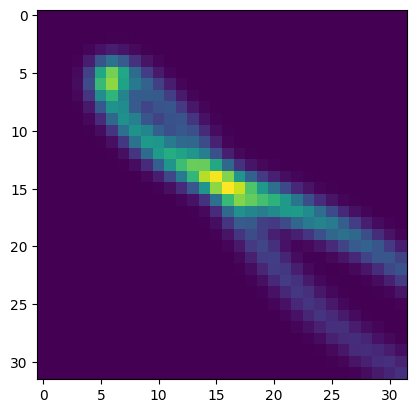

In [10]:
plt.figure()
plt.imshow(gen_img.reshape(32,32).cpu())
plt.show()

## Dataset generation
---



In [11]:
K_train = 1_000
K_test= 1000

img_size = 32

gen = decoder.decoder(img_size, "cpu") # Generator
def gen_dataset(N):
  orbit = torch.zeros(N,1,3)

  orbit[:,0,0] = torch.rand(N)*0.5
  orbit[:,0,1] = np.deg2rad(torch.rand(N)*20)
  orbit[:,0,2] = np.deg2rad(torch.rand(N)*20-10)

  gen_img = gen(orbit) # Image generation
  return orbit, gen_img

orbit_test, gen_img_test = gen_dataset(K_test)
orbit_train, gen_img_train = gen_dataset(K_train)


torch.Size([1000, 100, 4])
torch.Size([1000, 100, 4])


In [12]:
gen_img_test.shape

torch.Size([1000, 1024])

In [13]:
from torch.utils.data import TensorDataset, DataLoader

dataset_test = TensorDataset(gen_img_test, orbit_test)
dataset_train = TensorDataset(gen_img_train, orbit_train)

In [14]:
loader_train = DataLoader(dataset_train, batch_size=10, shuffle=True)
loader_test = DataLoader(dataset_test, batch_size=10, shuffle=False)

## Training

In [34]:
mse = torch.nn.MSELoss()
lambda_ = 0.
def single_epoch(lr, dataloader, optimizer, train = True, device = "cpu"):
    l_label_item = 0
    l_physics_item = 0
    for img, orbit_label in dataloader:
        img = img.to(device)
        orbit_label = orbit_label.to(device)

        orbit_pred = net(img)
        
        
        ecc = orbit_pred[:,0]
        inc = orbit_pred[:,1]
        argper = orbit_pred[:,2]


        l_label = mse(torch.stack((ecc,inc,argper),dim=-1)[:,None,:], orbit_label)
       
        img_from_pred = gen(torch.stack((torch.clamp(ecc,0,0.5),inc,argper),dim=-1)[:,None,:]).to(device)
        l_physics = mse(img_from_pred, img)
        
        
        
        l = lambda_ * l_label +  (1-lambda_) * l_physics


        l_label_item += l_label.item()/len(dataloader)
        l_physics_item += l_physics.item()/len(dataloader)

        if train:
            optimizer.zero_grad()
            l.backward()
            optimizer.step()

    return l_label_item, l_physics_item

In [35]:
loss_label = {"test" : [], "train" : [] }
loss_physics = {"test" : [], "train" : [] }

def train(net, nbr_iter = 100, lr = 0.001 , progressbar = True, start = 0 ):

    net = net.to(device)

    if progressbar:
        loop_obj = tqdm(range(start, nbr_iter,1))
    else :
        loop_obj = range(nbr_iter)


    optimizer = optim.Adam(net.parameters(), lr=lr,betas=(0.9,0.99))
    # optimizer = optim.SGD(net.parameters())

    for e in loop_obj:
        t_start_epoch = time.time()


        l_label_item, l_physics_item = single_epoch(lr, tqdm(loader_train), optimizer, train = True, device = device)
        loss_label["train"].append(l_label_item)
        loss_physics["train"].append(l_physics_item)

        l_label_item, l_physics_item = single_epoch(lr, tqdm(loader_test), optimizer, train = False, device = device)
        loss_label["test"].append(l_label_item)
        loss_physics["test"].append(l_physics_item)



        loss_label_train, loss_label_test = (loss_label["train"][-1]), (loss_label["test"][-1])
        loss_physics_train, loss_physics_test = (loss_physics["train"][-1]), (loss_physics["test"][-1])

        # torch.save({
        #     'epoch': e,
        #     'model_state_dict': net.state_dict(),
        #     'optimizer_state_dict': optimizer.state_dict(),
        #     'loss_pred_train': loss_pred_train,
        #     'loss_pred_test': loss_pred_test,
        #     'learning_rate' : lr
        #     }, path + "/model_"+str(e)+".pth")



        print(f"Epoch duration : {(time.time() - t_start_epoch)/60} minutes ")
        print("----- Loss function values -------")
        print("Train set")
        print(f"Loss_label: {loss_label_train}  -- Loss_physics: {loss_physics_train} ")
        print("Test set ")
        print(f"Loss_label: {loss_label_test}  -- Loss_physics: {loss_physics_test} ")

        # if progressbar:
        #     loop_obj.set_description(f"Loss_pred_train: {loss_pred_train},  Loss_pred_test: {loss_pred_test}")

In [17]:
net = torch.nn.Sequential(nn.Linear(img_size**2, 24),
                          nn.ReLU(),
                          nn.Linear(24, 24),
                          nn.ReLU(),
                          nn.Linear(24, 24),
                          nn.ReLU(),
                          nn.Linear(24, 3)

                          )

In [36]:
device = "cuda:0"
train(net, nbr_iter = 100, lr = 0.0001, progressbar = False )

  3%|▎         | 3/100 [00:00<00:04, 23.00it/s]

torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])


  9%|▉         | 9/100 [00:00<00:03, 25.21it/s]

torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])


 15%|█▌        | 15/100 [00:00<00:03, 24.89it/s]

torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])


 18%|█▊        | 18/100 [00:00<00:03, 24.36it/s]

torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])


 24%|██▍       | 24/100 [00:00<00:03, 24.49it/s]

torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])
torch.Size([10, 100, 4])


 27%|██▋       | 27/100 [00:01<00:03, 23.83it/s]

torch.Size([10, 100, 4])
torch.Size([10, 100, 4])


KeyboardInterrupt: 

## Testing

---

In [49]:
orbit = torch.zeros(1,1,3)

orbit[:,0,0] = 0.4
orbit[:,0,1] = np.deg2rad(2)
orbit[:,0,2] = np.deg2rad(9)

gen_img = gen(orbit) # Image generation

torch.Size([1, 100, 4])


In [50]:
res = net(gen_img.to("cuda:0"))

In [51]:
print("MSE error", mse(orbit, res.cpu()).item())
print(res)
print(orbit)

MSE error 0.014097504317760468
tensor([[ 0.4024,  0.0764, -0.0443]], device='cuda:0',
       grad_fn=<AddmmBackward0>)
tensor([[[0.4000, 0.0349, 0.1571]]])


In [52]:
gen_img_from_nn = gen(res[:,None,:])

torch.Size([1, 100, 4])


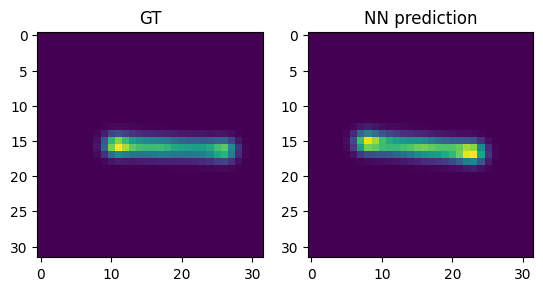

In [53]:
fig , ax = plt.subplots(1,2)
ax[0].imshow(gen_img.reshape(32,32).detach().cpu())
ax[0].set_title("GT")
ax[1].imshow(gen_img_from_nn.reshape(32,32).detach().cpu())
ax[1].set_title("NN prediction")
plt.show()